# Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import collections
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy.cluster import hierarchy
from scipy.spatial import distance
from features import categorical_features, skewed_features, unskewed_features, cols_idxs

## Read the data

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

Work around PowerTransformer bug: 
https://github.com/scikit-learn/scikit-learn/issues/14959

"This problem happens for any variable with a low variance but a large offset...  If the goal is to standardize the data, one workaround would be to pre-center the data prior to scaling with Yeo-Johnson."

In [3]:
pt = PowerTransformer()
pt.fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [4]:
# workaround according to https://github.com/scikit-learn/scikit-learn/issues/14959
# apply StandardScaler(with_std=False)
preprocessor = make_pipeline(
    StandardScaler(with_std=False),
    PowerTransformer(standardize=True),
)
preprocessor.fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))
# the error does not happen

array([[ 1.33453279],
       [ 0.48119188],
       [ 0.85696096],
       ...,
       [-1.50537684],
       [-0.98988697],
       [-1.61157313]])

In [5]:
df["per_capita_tax_income"] = StandardScaler(with_std=False).fit_transform(df["per_capita_tax_income"].values.reshape(-1, 1))

## Distribution of features

I plot the distribution of all features. The purpose is to see which features have approximately a bell shape and which ones are skewed or have outliers. To achieve good results, especially in linear regression, skewed features can be transformed in the preprocessing step to make them look more like a normal distribution. I will use the scikit-learn PowerTransformer for that purpose. (I have already used it successfully in the housing price project, where it yielded better results than just applying a log transformation).

I have first plotted all features without transformation. Set the variable apply_transformation = False to see this. Then through visual inspection I decided which features I wanted to transform. I put a list of the features in the features.py file in the skewed_features variable. Then I repeated the plot, but this time with PowerTransformer applied to skewed features (in orange color). Set the variable apply_transformation = True to see this.

The features with cantonal or regional (instead of communal) reference area can be distinguised in the plots because they have a more coarse-grained distributions (religion, unemployment, health premiums). It would probably improve the model performance to have this data on the commune level, but such data sets are not publicly available.

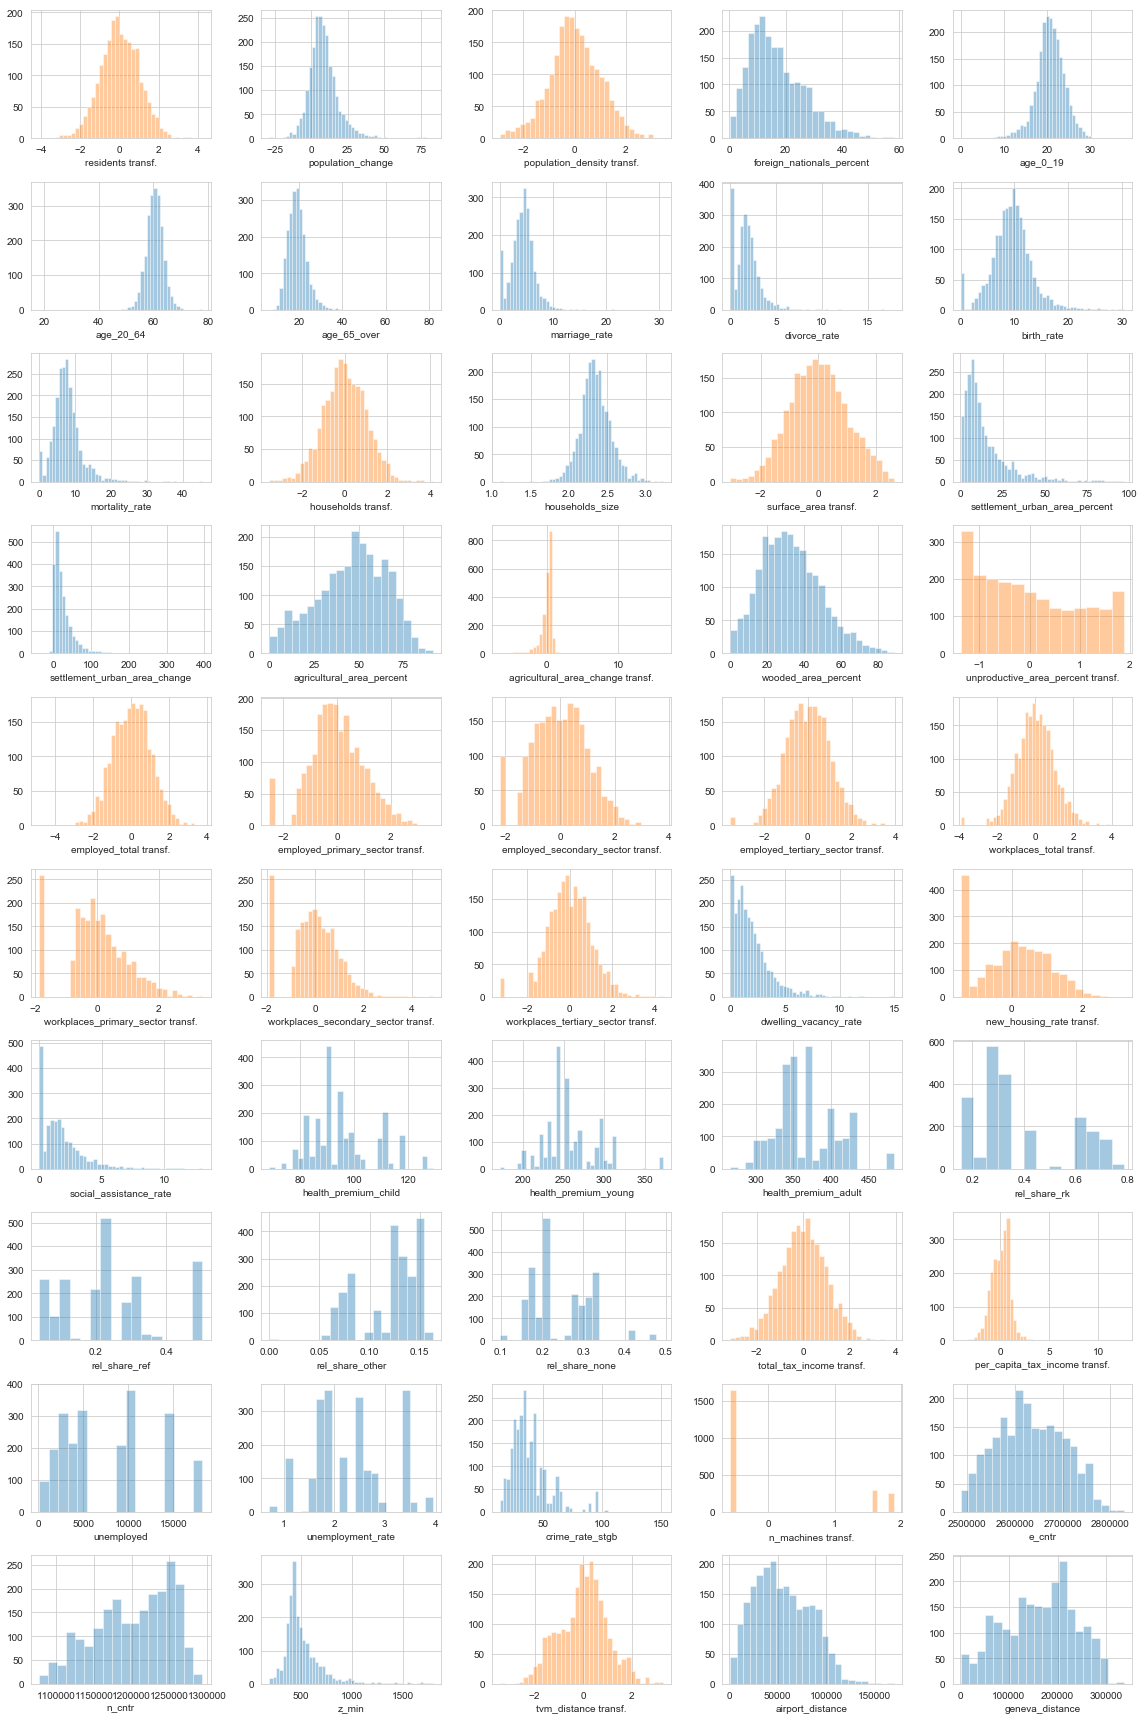

In [6]:
apply_transformation = True

cols = [col for col in df.columns if col not in categorical_features and col != "po_value"]
pt = PowerTransformer()
sns.set_style('whitegrid')
color_0 = sns.color_palette()[0]
color_1 = sns.color_palette()[1]
fig, axs = plt.subplots(10, 5, figsize = (16, 24))
for i, ax in enumerate(axs.flatten()):
    if i < len(cols):
        if not apply_transformation or cols[i] in unskewed_features:
            sns.distplot(df[cols[i]], kde = False, ax = ax, color=color_0)
        else:
            sns.distplot(pt.fit_transform(df[cols[i]].values.reshape(-1, 1)),
                         kde = False, ax = ax, color=color_1, axlabel=cols[i] + " transf.")
    else:
        ax.set_axis_off()
plt.tight_layout()

## Correlation
Next I look at the correlations between the features and especially between the features and the target variable, the po_value. This helps to

- identify the features that have the highest correlation with the target, they are potentially the most predictive and can be used in a reduced feature set model
- find correlations between features; strong correlations point to features that are redundant, and colinearities can lead to numerical problems as well as making it more difficult to identify the important features

Categorical features are excluded here, but will be looked at later on.

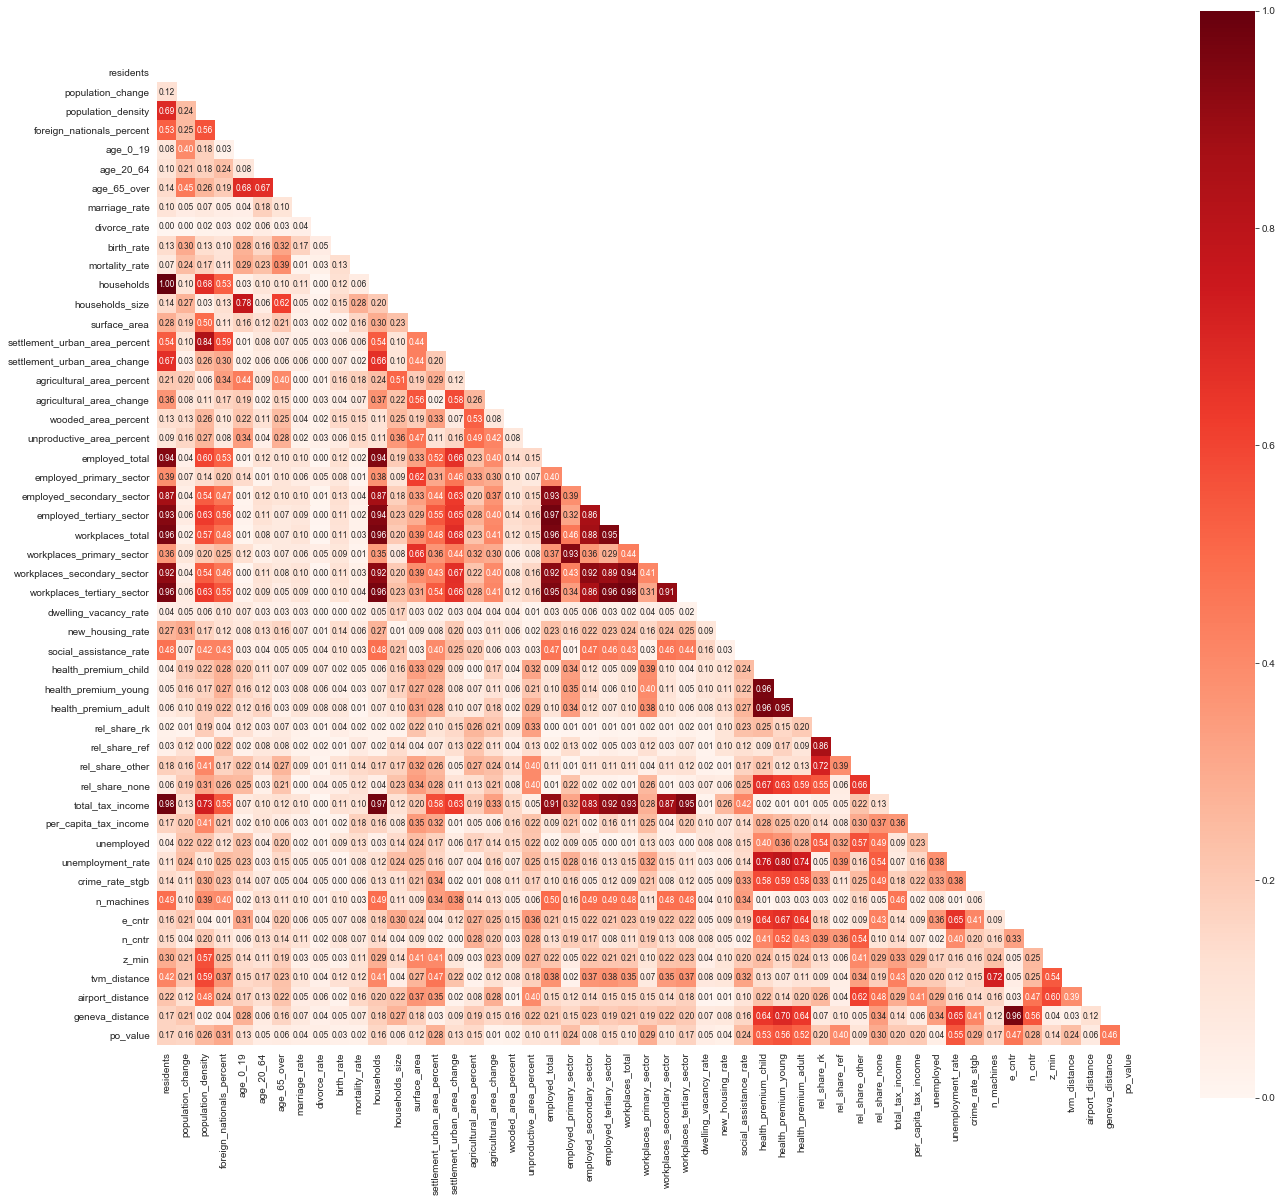

In [7]:
df2 = df.drop(columns=categorical_features)
po_values = df2["po_value"]
df2.drop(columns="po_value", inplace=True)
df2["po_value"] = po_values
pt = PowerTransformer()
for col in skewed_features:
    df2[col] = pt.fit_transform(df2[col].values.reshape(-1, 1))
corr = np.abs(df2.corr())

plt.figure(figsize = (22,20))
sns.heatmap(corr, annot = True, fmt = '.2f',
            square=True, vmin = 0, vmax = 1, cmap= 'Reds', mask = np.triu(corr), annot_kws = {"fontsize":"small"});

Correlation with target po_value:
- no really strong correlations, means we might not be able to get a highly predictive model
- health premiums, unemployment rate, east coordinate, religion have medium correlation with po_value
- population density, foreign nationals, urban area, primary sector workplaces, crime rate, north coordinate and ticket vending machine distance have at least some correlation with po_value

Collinearities:
- even though this view is not optimized to identify clusters of correlated features, one can see that a lot of features are similar to residents/households, which is mostly easy to comprehend: employed, workplaces, total tax income
- another group is health premiums (obvious), but less easy to understand why between health premiums and unemployment rate, no religion or east coordinate

### Computing clusters of features

I wanted to further understand what the clusters of correlated features are. I read some articles about the topic
- https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python
- https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

and I created a correlation matrix that is sorted to highlight the features that are close correlation-wise and also plotted a dendrogram which is a tree structure that visualizes the clustered features.


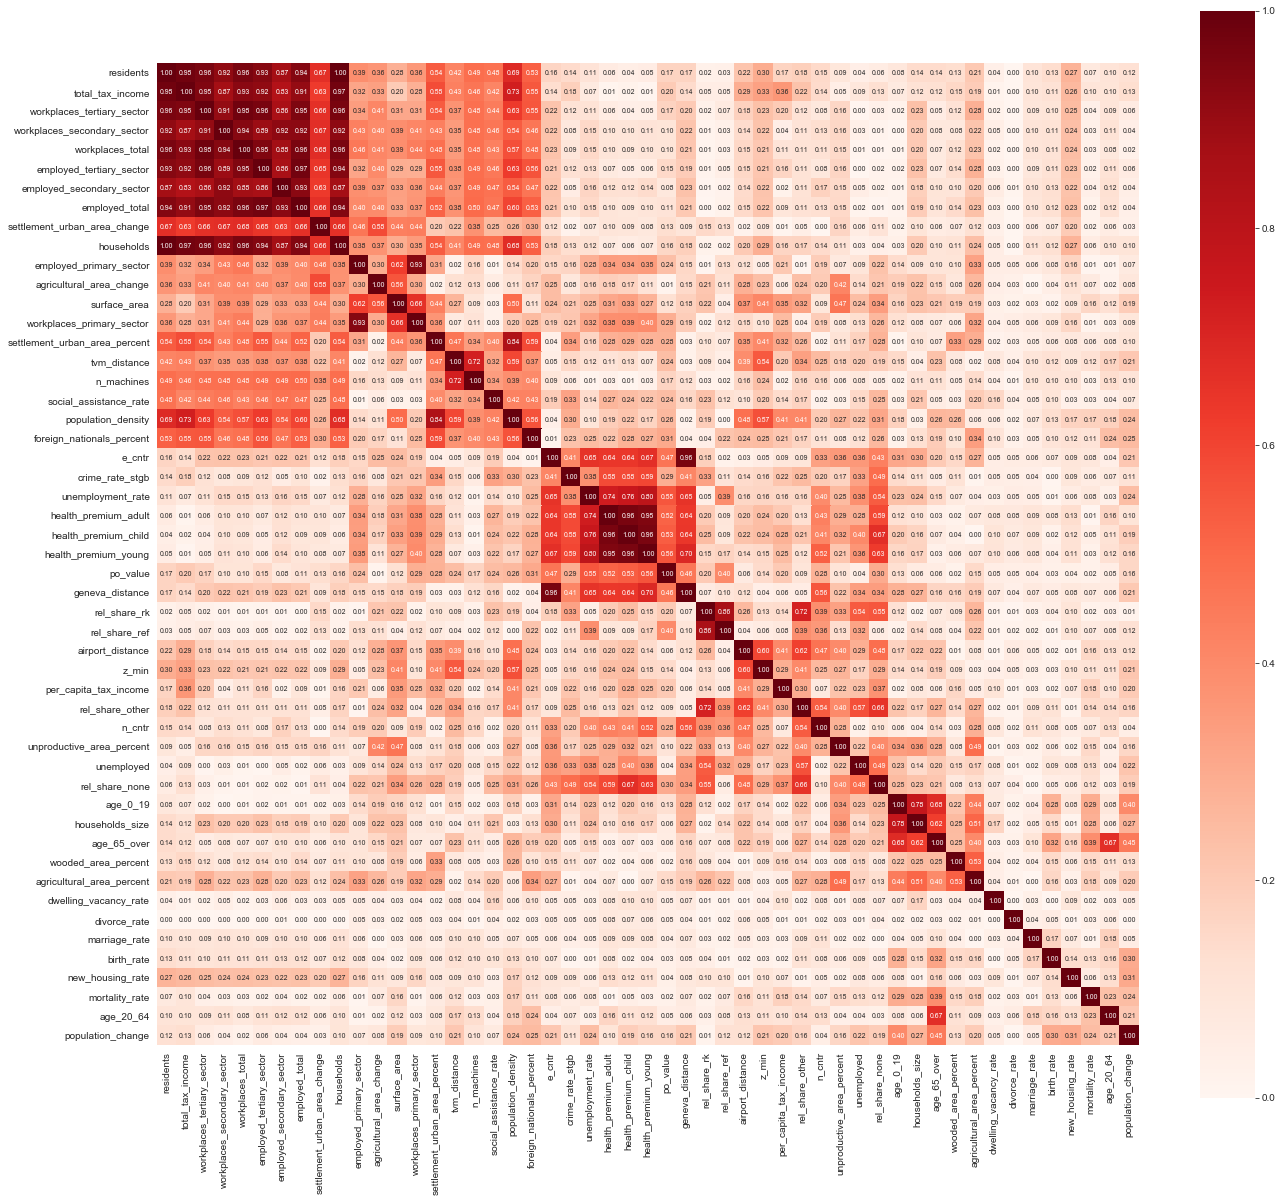

In [8]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

pdist = distance.pdist(df2.corr().abs().values) # pairwise distances, shape (1275,) (51*50/2)
linkage = hierarchy.linkage(pdist, method="ward")
cluster_idx = hierarchy.fcluster(linkage, 0.5 * pdist.max(), 'distance') # shape (51,)
clustered_cols = df2.columns[np.argsort(cluster_idx)]
clustered_corr = df2[clustered_cols].corr().abs()

plt.figure(figsize = (22,20))
sns.heatmap(clustered_corr, annot = True, fmt = '.2f',
            square=True, vmin = 0, vmax = 1, cmap= 'Reds', annot_kws = {"fontsize":"x-small"}); # mask = np.triu(corr), 

In the heatmap, the clusters can be recognized as squares along the diagonal. The residents/households cluster is easily recognizable, followed by six or seven other clusters.

The nice property of the dendrogram is the ability to clearly distinguish the clusters. The number of colored cluster is influenced by the color threshold parameter. 70% of the maximum pairwise distance seems to be a common value (e.g. Matlab default). I chose a lower value (50%) to have more clusters (11) that are more cohesive and that can be easier "explained".

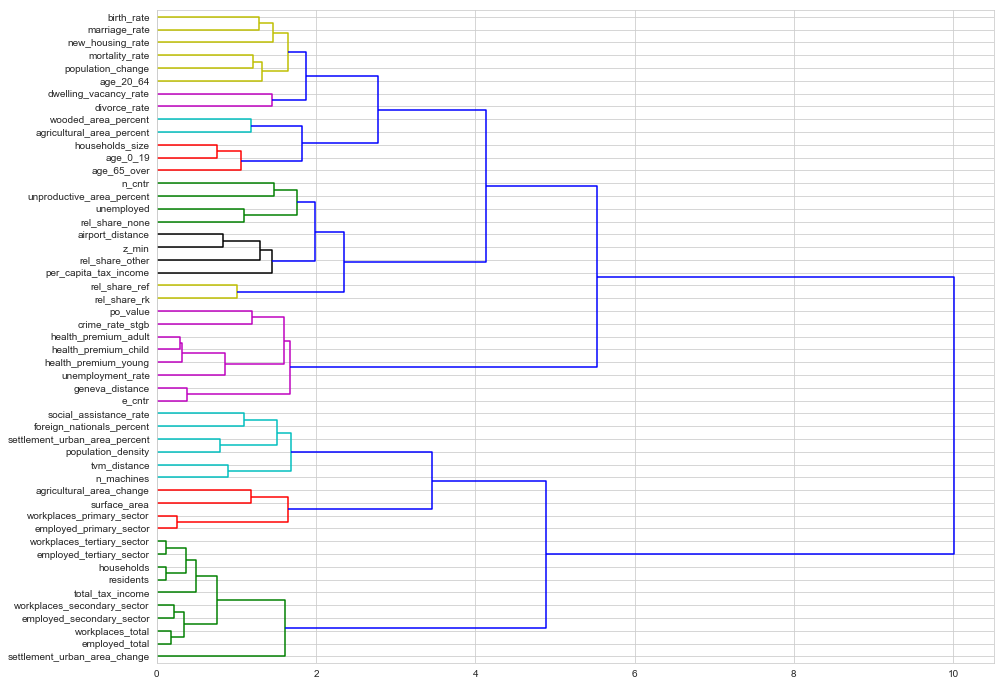

In [9]:
plt.figure(figsize = (15,12))
hierarchy.dendrogram(linkage, labels=df2.columns, color_threshold=0.5 * pdist.max(),
                     orientation="right", leaf_font_size="medium");

In [10]:
print("{} clusters".format(cluster_idx.max()))
clusters = collections.defaultdict(list)
for x in zip(cluster_idx, df2.columns):
    clusters[x[0]].append(x[1])
for it in sorted(clusters.items()):
    print(it)

11 clusters
(1, ['residents', 'households', 'settlement_urban_area_change', 'employed_total', 'employed_secondary_sector', 'employed_tertiary_sector', 'workplaces_total', 'workplaces_secondary_sector', 'workplaces_tertiary_sector', 'total_tax_income'])
(2, ['surface_area', 'agricultural_area_change', 'employed_primary_sector', 'workplaces_primary_sector'])
(3, ['population_density', 'foreign_nationals_percent', 'settlement_urban_area_percent', 'social_assistance_rate', 'n_machines', 'tvm_distance'])
(4, ['health_premium_child', 'health_premium_young', 'health_premium_adult', 'unemployment_rate', 'crime_rate_stgb', 'e_cntr', 'geneva_distance', 'po_value'])
(5, ['rel_share_rk', 'rel_share_ref'])
(6, ['rel_share_other', 'per_capita_tax_income', 'z_min', 'airport_distance'])
(7, ['unproductive_area_percent', 'rel_share_none', 'unemployed', 'n_cntr'])
(8, ['age_0_19', 'age_65_over', 'households_size'])
(9, ['agricultural_area_percent', 'wooded_area_percent'])
(10, ['divorce_rate', 'dwelling

### Details of clusters

I give the clusters a name and try to find an "explanation", some common property of the features of each cluster. The number behind each feature is the correlation with the po_value.

#### Residents cluster
Many features are closely related to the number of residents. The relations are intutively quite obvious (more residents, more households, workplaces, total tax income etc.)
- residents 17
- households 16
- settlement_urban_area_change 13
- employed_total 11
- employed_secondary_sector 8
- employed_tertiary_sector 15
- workplaces_total 10
- workplaces_secondary_sector 10
- workplaces_tertiary_sector 17
- total_tax_income 20

#### Primary sector cluster
The area of a commune and the size of the primary sector (farming, logging etc.) are related
- surface_area 12
- agricultural_area_change 1
- employed_primary_sector 24
- workplaces_primary_sector 29

#### Urbanity cluster
These are features where higher values often come with more urban communes.

- population_density 26
- foreign_nationals_percent 31
- settlement_urban_area_percent 28
- social_assistance_rate 24
- n_machines 17
- tvm_distance 24

#### Health premium cluster
It is an interesting observation that health premiums (result of health costs) and features like unemployment rate or geography are related so much.

- health_premium_child 53
- health_premium_young 56 
- health_premium_adult 52
- unemployment_rate 55
- crime_rate_stgb 29
- e_cntr 47
- geneva_distance 46

#### Religion cluster
- rel_share_rk 20
- rel_share_ref 40

#### Mountains cluster
I call it this because z_min is the elevation and airport_distance is also about a commune being remote. Other religions (not catholic or protestant, e.g. muslims) are less frequent there, and per capita tax income is lower.
- rel_share_other 9
- per_capita_tax_income 20
- z_min 14
- airport_distance 6

#### No religion cluster
It's hard to give a name to this one. There is medium correlation between number of unemployed people and the share of people without religion.
- unproductive_area_percent 10
- rel_share_none 30
- unemployed 4
- n_cntr 28

#### Age cluster
It seems intuitive that a higher share of young people relates to larger household sizes (families), whereas there is the opposite effect for old people.
- age_0_19 13
- age_65_over 6
- households_size 6


#### Farm/forest cluster
More farm land, less trees.
- agricultural_area_percent 15
- wooded_area_percent 2

#### Useless "cluster"
Two unrelated features that seem to be pretty useless to predict the target variable.
- divorce_rate 5
- dwelling_vacancy_rate 5

#### Useless "cluster"
More not so related features without correlation to the target.
- population_change 16
- age_20_64 5
- marriage_rate 4
- birth_rate 3
- mortality_rate 2
- new_housing_rate 4

In [11]:
df[["divorce_rate", "dwelling_vacancy_rate"]].corr()

,divorce_rate,dwelling_vacancy_rate
divorce_rate,1.000000,0.000958
dwelling_vacancy_rate,0.000958,1.000000


### Correlation of categorical to numerical variables
I use the **correlation ratio** $\eta$ (eta) [(Wikipedia)](https://en.wikipedia.org/wiki/Correlation_ratio) to measure the relationship between the categorical variables (canton, language, typology) and the other variables, which are numerical (including the target). $\eta$ takes values between 0 and 1. $\eta = 0$ is the extreme case where the mean is the same for all categories (the category cannot help to explain the other variable), and $\eta = 1$ is the other extreme case where there is no variance inside of the categories, i.e. the category of a variable can fully predict its value.

Reference: Shaked Zychlinski, "The Search for Categorical Correlation", https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [12]:
# source: Shaked Zychlinski: "The Search for Categorical Correlation"
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
def shakeds_correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(round(numerator / denominator, 12)) # rounding and sqrt added by me
    return eta

In [13]:
# I panda-fied Shaked Zychlinski's function and also apply the square root to the result
def correlation_ratio(data, category_col, measurement_col):
    grouped = data.groupby(by=category_col)
    # mean of items in category (was y_avg_array)
    group_means = grouped[measurement_col].mean()
    # number of items in category (was n_array)
    group_size = grouped.size() 
    # total number of values (was np.sum(n_array))
    total_size = grouped.size().sum()
    # overall weighted mean (was y_total_avg)
    total_mean = (group_means * group_size).sum() / total_size
    
    numerator = (group_size * (group_means - total_mean)**2).sum()
    denominator = ((data[measurement_col] - total_mean)**2).sum()
    if numerator == 0:
        return 0.0
    else:
        return math.sqrt(round(numerator / denominator, 12)) # rounding and sqrt added by me

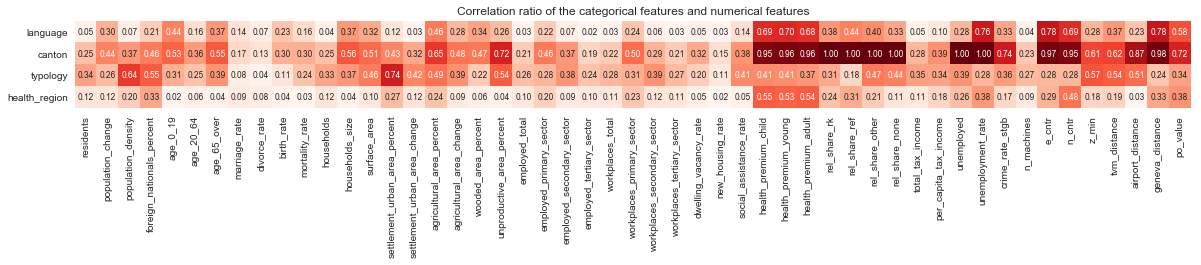

In [14]:
correlation_ratios = {}
other_features = [it for it in df.columns if it not in categorical_features]
other_features.remove("po_value")
other_features.append("po_value") # put it at the end
# other_features = ["employed_total"]
for cat in categorical_features:
    correlation_ratios[cat] = []
    for var in other_features:
        correlation_ratios[cat].append(correlation_ratio(df, cat, var))

df_correlation_ratios = pd.DataFrame.from_dict(correlation_ratios)
df_correlation_ratios.index = other_features

plt.figure(figsize=(20,5))
sns.heatmap(df_correlation_ratios.transpose(), square=True, annot = True, fmt = '.2f',
            annot_kws = {"fontsize":"small"}, cmap= 'Reds', cbar=False)
plt.title("Correlation ratio of the categorical features and numerical features")
plt.show()

Interpretation:
- first some obvious things: the correlation ratio from canton to some features is naturally close to 1 
    - for features that are measured at the canton level: religion, unemployment, health premiums (sub-cantonal regions with limited variance)
    - for geographic features, cantons are natural clusters of communes by location
- correlation ratio to target po_value:
    - from canton to po_value it is good, I expect the models to use the canton as an important feature
    - from language to po_value also medium to high, might also be an important feature
    - typology is not so good, which is a bit disappointing because in theory it contains a lot of information (it is an engineered feature)
- other observations:
    - language to unemployment rate is rather high, there seem to be significant differences in unemployment in the different language regions of Switzerland
    - same for health premiums, for some reason they are significantly higher in french-speaking part of Switzerland  

### Correlation of categorical variables
Correlation (or correlation ratio) cannot be used to measure the association between two categorical variables. I use the **uncertainty coefficient**, or Theil's U [(Wikipedia)](https://en.wikipedia.org/wiki/Uncertainty_coefficient) instead. It is based on information entropy and tells us, knowing one variable, how many bits of the other variable can be predicted. Again, the range is 0 to 1, with 0 meaning no association and 1 meaning the other variable can be fully predicted. Note that this function is not symmetrical.

Reference: Shaked Zychlinski, "The Search for Categorical Correlation", https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [15]:
# source: Shaked Zychlinski: "The Search for Categorical Correlation"
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://github.com/shakedzy/dython
from collections import Counter
import scipy.stats as ss

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    #  given Y, what fraction of the bits of X can we predict?
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

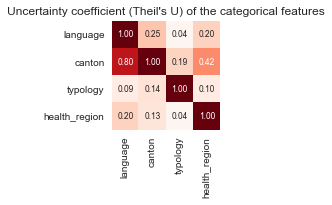

y-axis given, x-axis predict


In [16]:
theils_us = {}
for x in categorical_features:
    theils_us[x] = []
    for y in categorical_features:
        theils_us[x].append(theils_u(df[x], df[y]))

df_theils_us = pd.DataFrame.from_dict(theils_us)
df_theils_us.index = categorical_features

plt.figure(figsize=(2 ,2))
sns.heatmap(df_theils_us, square=True, annot = True, fmt = '.2f',
            annot_kws = {"fontsize":"small"}, cmap= 'Reds', cbar=False)
plt.title("Uncertainty coefficient (Theil's U) of the categorical features")
plt.show()
print("y-axis given, x-axis predict")

Interpretation:
- knowing the canton, you can predict the language with high probability (because most cantons have only one language)
- combined with the previous results (correlation ration with po_value, where language is weaker), that could mean that language is not an important feature in the presence of the canton; but we will have to see in practice

## Scatterplots

The scatterplots of features against po_value confirm the findings from above. Most features do not look related visually. The usefulness of some of the better ones is reduced by the fact that they are not per commune.

Blue plots are untransformed features, orange plots are transformed.

### Numerical variables

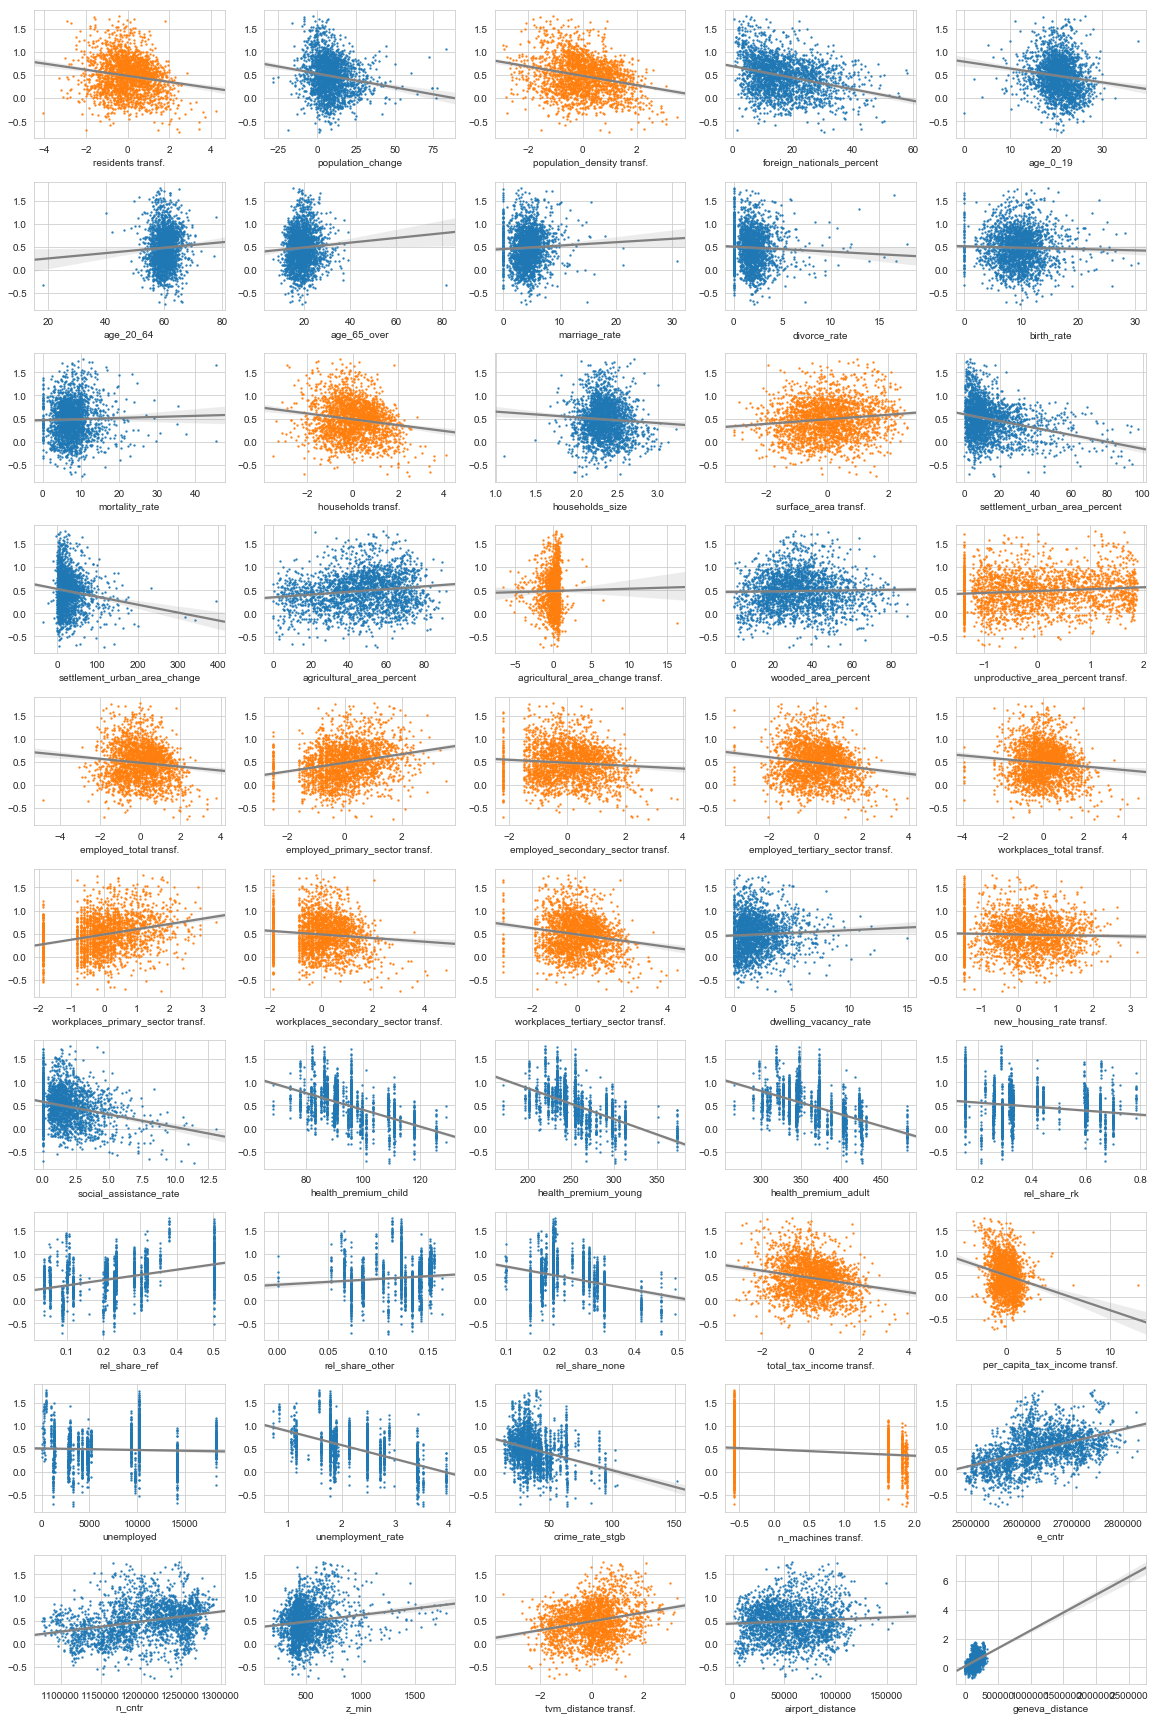

In [17]:
cols = [col for col in df.columns if col not in categorical_features and col != "po_value"]
pt = PowerTransformer()
fig, axs = plt.subplots(10, 5, figsize = (16, 24))
for i, ax in enumerate(axs.flatten()):
    if i < len(cols):
#    if i < 3:
        if cols[i] in unskewed_features:
            sns.regplot(x=df[cols[i]], y=df["po_value"], ax = ax, scatter_kws={'s': 2, "color": color_0}, line_kws={"color": "grey"})
            ax.set_ylabel("")
        else:
            x = pt.fit_transform(df[cols[i]].values.reshape(-1, 1))
            sns.regplot(x=x.reshape(-1), y=df["po_value"], ax = ax, scatter_kws={'s': 2, "color": color_1}, line_kws={"color": "grey"})
            ax.set_xlabel(cols[i] + " transf.")
            ax.set_ylabel("")
    else:
        ax.set_axis_off()
plt.tight_layout()

### Categorical variables

A visible problem of the categorical features is that they are quite unbalanced. 

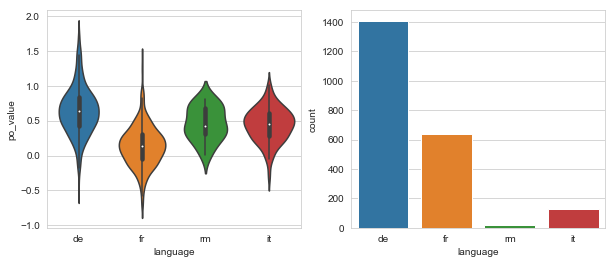

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
sns.violinplot(data=df, x="language", y="po_value", ax=ax1)
sns.countplot(df["language"], ax=ax2);

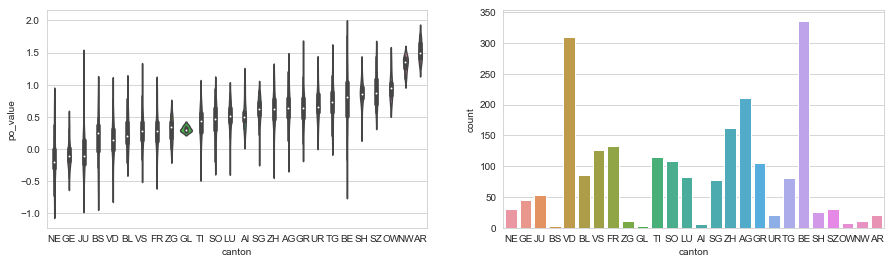

In [19]:
grouped_cantons = df.groupby(by="canton").mean()["po_value"].sort_values()
# print(grouped_cantons)
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize = (15, 4))
sns.violinplot(data=df, x="canton", y="po_value", order=grouped_cantons.index,ax=ax1)
sns.countplot(df["canton"],  order=grouped_cantons.index, ax=ax2);

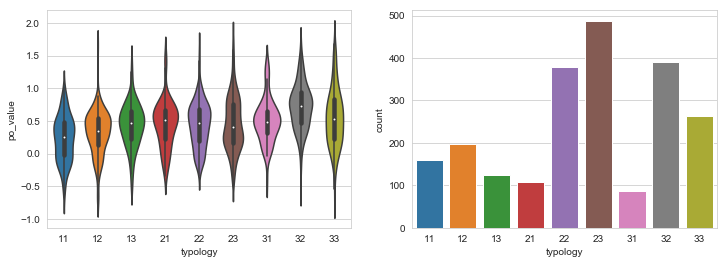

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
sns.violinplot(data=df, x="typology", y="po_value", ax=ax1)
sns.countplot(df["typology"], ax=ax2);